In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
from crf.comlid_crf import *
from helper.dataset_reader import read_tsv

In [20]:
langid = LanguageIdentifier()

In [3]:
data = read_tsv('../dataset/all-merged-data-140422.tsv')

In [4]:
all_data, words, tags = data

In [23]:
# create list of tuples from all words and all tags
word_tag = list(zip(words, tags))
# print(word_tag)
# convert list to dataframe
df_wordtag = pd.DataFrame(word_tag, columns=['Token','Label'])
# df_wordtag

In [15]:
words = list(set(df_wordtag['Token'].values))
words.append("ENDPAD")
num_words = len(words)
# print(num_words)

In [16]:
tags = list(set(df_wordtag["Label"].values))
num_tags = len(tags)
# print(num_tags)

In [22]:
dt_pair = langid.data_transformer(data)
dt_pair[0]

[('Tumben', 'ID'),
 ('xl', 'O'),
 ('banter', 'JV'),
 ('go', 'JV'),
 ('download', 'EN'),
 (',', 'O'),
 (',', 'O'),
 ('download', 'EN'),
 ('video', 'ID'),
 ('tom', 'O'),
 ('jerry', 'O'),
 ('ya', 'ID'),
 ('masuk', 'ID'),
 ('kie', 'JV'),
 ('https://t.co/SmrXmut7wk', 'O')]

In [24]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

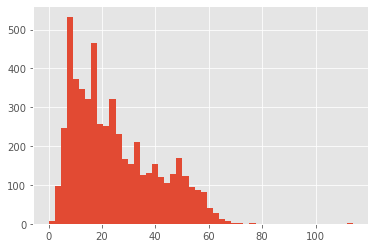

In [27]:
plt.hist([len(s) for s in dt_pair], bins=50)
plt.show()

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in dt_pair]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in dt_pair]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [33]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [34]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1344500   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 7)             1407      
Total params: 1,466,707
Trainable params: 1,466,707
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

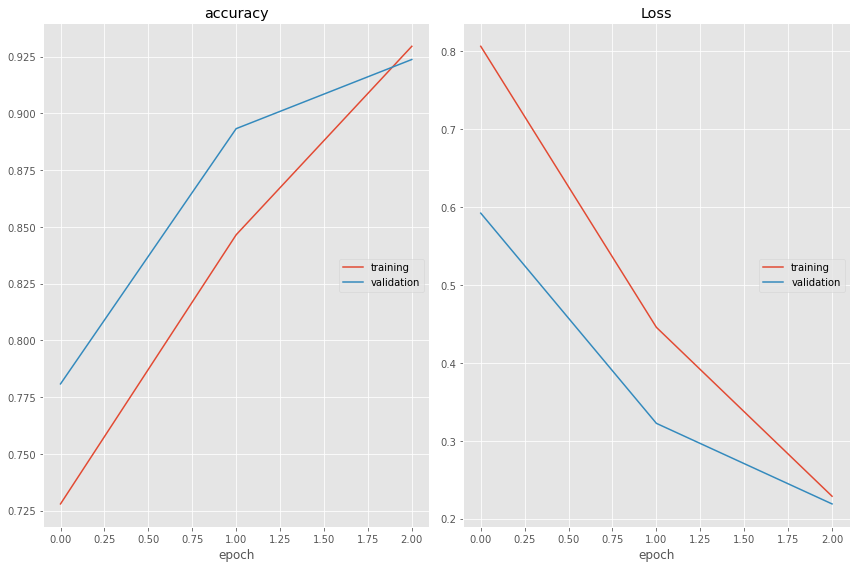

accuracy
	training         	 (min:    0.728, max:    0.930, cur:    0.930)
	validation       	 (min:    0.781, max:    0.924, cur:    0.924)
Loss
	training         	 (min:    0.229, max:    0.807, cur:    0.229)
	validation       	 (min:    0.219, max:    0.592, cur:    0.219)

Epoch 00003: val_loss improved from 0.32240 to 0.21893, saving model to model_weights.h5
CPU times: user 1min 45s, sys: 35.7 s, total: 2min 21s
Wall time: 29.3 s


In [37]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [38]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 1s 12ms/step - loss: 0.2189 - accuracy: 0.9237


[0.21892817318439484, 0.9237057566642761]

In [47]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
@ziarah_kubur  O	JV
Iki            JV	JV
mau            JV	ID
diewangi       JV	JV
udan           JV	JV
mas            JV	JV
,              O	O
gado2          JV	O
orderane       MIX-ID-JV	JV
.              O	O
Nek            JV	JV
neng           JV	JV
makaroni       JV	JV
mulai          ID	ID
buka           ID	JV
tekan          JV	JV
sore           JV	JV
mung           JV	JV
dadi           JV	JV
penonton       ID	JV
akunku         JV	JV
mas            JV	JV
.              O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Hanyut         O	O
Han